<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento//BDML_202302/blob/main/Lecture07/Notebook_SS07_Classification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Classification

To work through the steps of probability-based classification, we’ll use a real dataset on loans and credit from a set of local lenders in Germany (taken from the UC Irvine Machine Learning Repository and cleaned for our purposes). 

Credit scoring is a classic problem of classification, and it remains one of the big application domains for ML: use previous loan results (default versus payment) to train a model that can predict the performance of potential new loans.

\begin{align}
Default=f(x) + u
\end{align}

where $Default=I(Default=1)$



In [1]:
#Cargar librerías 
require("pacman")
p_load(tidyverse)
set.seed(1011)

Loading required package: pacman



In [2]:
#Leer los datos 
credit <- readRDS(url("https://github.com/ignaciomsarmiento/datasets/blob/main/credit_class.rds?raw=true"))
head(credit)

,Default,duration,amount,installment,age,history,purpose,foreign,rent
,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,0,6,1169,4,67,terrible,goods/repair,foreign,FALSE
2,1,48,5951,2,22,poor,goods/repair,foreign,FALSE
3,0,12,2096,2,49,terrible,edu,foreign,FALSE
4,0,42,7882,2,45,poor,goods/repair,foreign,FALSE
5,1,24,4870,3,53,poor,newcar,foreign,FALSE
6,0,36,9055,2,35,poor,edu,foreign,FALSE


In [3]:
prop.table(table(credit$foreign))*100


   <NA> foreign  german 
    0.0    96.3     3.7 

In [4]:
default<-credit$Default  #defino ahora va a servir después

#mutación de factores
credit<-credit %>% mutate(Default=factor(Default,levels=c(0,1),labels=c("No","Si")),
                          history=factor(history,levels=c("good","poor","terrible"),labels=c("buena","mala","terrible")),
                          foreign=factor(foreign,levels=c("foreign","german"),labels=c("extranjero","aleman")),
                          purpose=factor(purpose,levels=c("newcar","usedcar","goods/repair","edu", "biz" ),labels=c("auto_nuevo","auto_usado","bienes","educacion","negocios")))         

In [5]:
head(credit)

,Default,duration,amount,installment,age,history,purpose,foreign,rent
,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,No,6,1169,4,67,terrible,bienes,extranjero,FALSE
2,Si,48,5951,2,22,mala,bienes,extranjero,FALSE
3,No,12,2096,2,49,terrible,educacion,extranjero,FALSE
4,No,42,7882,2,45,mala,bienes,extranjero,FALSE
5,Si,24,4870,3,53,mala,auto_nuevo,extranjero,FALSE
6,No,36,9055,2,35,mala,educacion,extranjero,FALSE


In [6]:
table(credit$foreign)


extranjero     aleman 
       963         37 

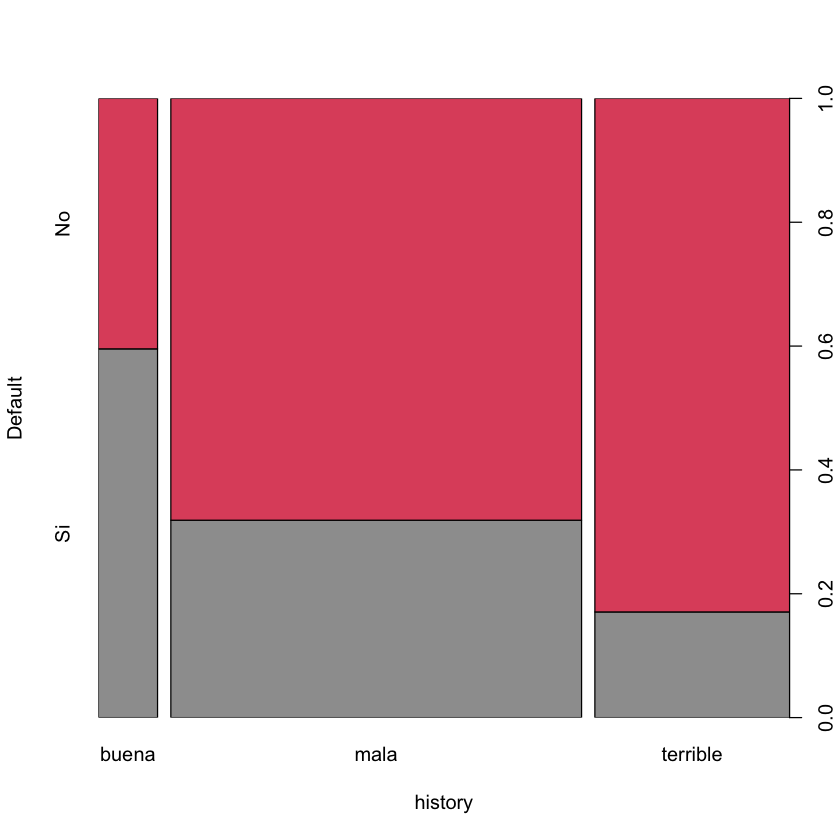

In [7]:
## plot a mosaic
plot(Default ~ history, data=credit, col=c(8,2), ylab="Default") 


## Estimación Logit

\begin{align}
p_i &=\frac{e^{X_i\beta}}{1+e^{X_i\beta}}
\end{align}


In [8]:
mylogit <- glm(Default~., data = credit, family = "binomial")
summary(mylogit,type="text")


Call:
glm(formula = Default ~ ., family = "binomial", data = credit)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.936e-01  4.579e-01  -0.423  0.67239    
duration           2.666e-02  8.152e-03   3.270  0.00108 ** 
amount             9.793e-05  3.670e-05   2.668  0.00763 ** 
installment        2.361e-01  7.687e-02   3.072  0.00213 ** 
age               -1.598e-02  7.348e-03  -2.175  0.02964 *  
historymala       -1.101e+00  2.490e-01  -4.424 9.67e-06 ***
historyterrible   -1.849e+00  2.837e-01  -6.518 7.13e-11 ***
purposeauto_usado -1.702e+00  3.273e-01  -5.201 1.98e-07 ***
purposebienes     -7.551e-01  1.867e-01  -4.044 5.25e-05 ***
purposeeducacion  -1.473e-01  3.263e-01  -0.451  0.65166    
purposenegocios   -8.501e-01  2.801e-01  -3.036  0.00240 ** 
foreignaleman     -1.322e+00  5.814e-01  -2.274  0.02298 *  
rentTRUE           5.702e-01  1.944e-01   2.934  0.00335 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 

## Prediction


\begin{align}
\hat{p}_i &=\frac{e^{X_i\hat{\beta}}}{1+e^{X_i\hat{\beta}}}
\end{align}

In [9]:

credit<- credit  %>% mutate(prob_hat=predict(mylogit,newdata = credit, type = "response")) #type = "response" gives the predicted probabilities.

head(credit  %>% select(Default,prob_hat))


,Default,prob_hat
,<fct>,<dbl>
1,No,0.06602463
2,Si,0.48318910
3,No,0.12179580
4,No,0.39995570
5,Si,0.42139444
6,No,0.57856013


## Classification 

\begin{align}
\hat{Y}_i= 1[\hat{p}_i >0.5]
\end{align}

In [10]:
rule <- 1/2 # Bayes Rule

credit <-  credit  %>% mutate(Default_hat=ifelse(prob_hat>rule,1,0))    ## predicted class labels

head(credit  %>% select(Default,prob_hat,Default_hat))

,Default,prob_hat,Default_hat
,<fct>,<dbl>,<dbl>
1,No,0.06602463,0
2,Si,0.48318910,0
3,No,0.12179580,0
4,No,0.39995570,0
5,Si,0.42139444,0
6,No,0.57856013,1


## Aside: Dummy Vars

In [11]:
p_load("caret")
dmy <- dummyVars(" ~ .", data = credit) # One-hot-encoding
head(dmy)

$call
dummyVars.default(formula = " ~ .", data = credit)

$form
~.
<environment: 0x7fef41c4f9c8>

$vars
 [1] "Default"     "duration"    "amount"      "installment" "age"        
 [6] "history"     "purpose"     "foreign"     "rent"        "prob_hat"   
[11] "Default_hat"

$facVars
[1] "Default" "history" "purpose" "foreign" "rent"   

$lvls
$lvls$Default
[1] "No" "Si"

$lvls$history
[1] "buena"    "mala"     "terrible"

$lvls$purpose
[1] "auto_nuevo" "auto_usado" "bienes"     "educacion"  "negocios"  

$lvls$foreign
[1] "extranjero" "aleman"    

$lvls$rent
[1] NA      "FALSE" "TRUE" 


$sep
[1] "."


In [12]:
credit <- data.frame(predict(dmy, newdata = credit))

In [13]:
head(credit)

,Default.No,Default.Si,duration,amount,installment,age,history.buena,history.mala,history.terrible,purpose.auto_nuevo,⋯,purpose.bienes,purpose.educacion,purpose.negocios,foreign.extranjero,foreign.aleman,rent.NA,rent.FALSE,rent.TRUE,prob_hat,Default_hat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,6,1169,4,67,0,0,1,0,⋯,1,0,0,1,0,0,1,0,0.06602463,0
2,0,1,48,5951,2,22,0,1,0,0,⋯,1,0,0,1,0,0,1,0,0.48318910,0
3,1,0,12,2096,2,49,0,0,1,0,⋯,0,1,0,1,0,0,1,0,0.12179580,0
4,1,0,42,7882,2,45,0,1,0,0,⋯,1,0,0,1,0,0,1,0,0.39995570,0
5,0,1,24,4870,3,53,0,1,0,1,⋯,0,0,0,1,0,0,1,0,0.42139444,0
6,1,0,36,9055,2,35,0,1,0,0,⋯,0,1,0,1,0,0,1,0,0.57856013,1


## Out of sample prediction

In [14]:
credit<- credit  %>% mutate(Default=factor(Default.Si,levels=c(0,1),labels=c("No","Si")))

In [15]:
inTrain <- createDataPartition(
  y = credit$Default.Si,## La variable dependiente u objetivo 
  p = .7, ## Usamos 70%  de los datos en el conjunto de entrenamiento 
  list = FALSE)


train <- credit[ inTrain,]
test  <- credit[-inTrain,]

In [16]:
head(train)

,Default.No,Default.Si,duration,amount,installment,age,history.buena,history.mala,history.terrible,purpose.auto_nuevo,⋯,purpose.educacion,purpose.negocios,foreign.extranjero,foreign.aleman,rent.NA,rent.FALSE,rent.TRUE,prob_hat,Default_hat,Default
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,0,1,48,5951,2,22,0,1,0,0,⋯,0,0,1,0,0,1,0,0.4831891,0,Si
3,1,0,12,2096,2,49,0,0,1,0,⋯,1,0,1,0,0,1,0,0.1217958,0,No
5,0,1,24,4870,3,53,0,1,0,1,⋯,0,0,1,0,0,1,0,0.4213944,0,Si
6,1,0,36,9055,2,35,0,1,0,0,⋯,1,0,1,0,0,1,0,0.5785601,1,No
9,1,0,12,3059,2,61,0,1,0,0,⋯,0,0,1,0,0,1,0,0.1263817,0,No
11,0,1,12,1295,3,25,0,1,0,1,⋯,0,0,1,0,0,0,1,0.5076477,1,Si


### Logit

In [17]:
ctrl<- trainControl(method = "cv",
                    number = 5,
                    classProbs = TRUE,
                    verbose=FALSE,
                    savePredictions = T)


In [18]:
set.seed(1410)
mylogit_caret <- train(Default~duration+amount+installment+age+
                       history.buena+history.mala+
                       purpose.auto_nuevo+purpose.auto_usado+purpose.bienes+purpose.educacion+
                       foreign.extranjero+
                       +rent.TRUE, 
                       data = train, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial")


mylogit_caret

Generalized Linear Model 

700 samples
 12 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 561, 559, 560, 560 
Resampling results:

  Accuracy   Kappa  
  0.7185148  0.14365


In [19]:
predictTest_logit <- data.frame(
  obs = test$Default,                                    ## observed class labels
  predict(mylogit_caret, newdata = test, type = "prob"),         ## predicted class probabilities
  pred = predict(mylogit_caret, newdata = test, type = "raw")    ## predicted class labels
)


In [20]:
head(predictTest_logit)

,obs,No,Si,pred
,<fct>,<dbl>,<dbl>,<fct>
1,No,0.9495503,0.05044975,No
4,No,0.6613619,0.33863813,No
7,No,0.8174441,0.18255586,No
8,No,0.7748455,0.22515449,No
10,Si,0.6093878,0.39061224,No
14,Si,0.8519662,0.14803376,No


## Árboles

In [22]:

set.seed(123)
class_arboles <- train(Default~duration+amount+installment+age+
                       history.buena+history.mala+
                       purpose.auto_nuevo+purpose.auto_usado+purpose.bienes+purpose.educacion+
                       foreign.extranjero+
                       +rent.TRUE, 
                       data = train, 
                       method = "rpart",
                       trControl = ctrl,
                        tuneLength=100)


class_arboles

CART 

700 samples
 12 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 561, 559, 560, 560 
Resampling results across tuning parameters:

  cp            Accuracy   Kappa     
  0.0000000000  0.6886471  0.18966879
  0.0004686036  0.6886471  0.18966879
  0.0009372071  0.6886471  0.18966879
  0.0014058107  0.6886471  0.18966879
  0.0018744142  0.6886471  0.18966879
  0.0023430178  0.6944025  0.20056834
  0.0028116214  0.6929636  0.19260697
  0.0032802249  0.6972289  0.19129958
  0.0037488285  0.6986575  0.19375656
  0.0042174321  0.6986575  0.19375656
  0.0046860356  0.6986575  0.18882515
  0.0051546392  0.6986575  0.18882515
  0.0056232427  0.7000861  0.19152098
  0.0060918463  0.7000861  0.19152098
  0.0065604499  0.7029432  0.18820186
  0.0070290534  0.7029432  0.18820186
  0.0074976570  0.7029432  0.18820186
  0.0079662605  0.7029432  0.18820186
  0.0084348641  0.7029432  0.18820186
  0.0089034677  0.7029432  0.

In [23]:
predictTest_arbol <- data.frame(
  obs = test$Default,                                    ## observed class labels
  predict(class_arboles, newdata = test, type = "prob"),         ## predicted class probabilities
  pred = predict(class_arboles, newdata = test, type = "raw")    ## predicted class labels
)

head(predictTest_arbol)

,obs,No,Si,pred
,<fct>,<dbl>,<dbl>,<fct>
1,No,0.7496112,0.2503888,No
4,No,0.7496112,0.2503888,No
7,No,0.7496112,0.2503888,No
8,No,0.7496112,0.2503888,No
10,Si,0.7496112,0.2503888,No
14,Si,0.7496112,0.2503888,No


In [24]:
# Accuracy
mean(predictTest_arbol$obs==predictTest_arbol$pred)

[1] 0.6733333

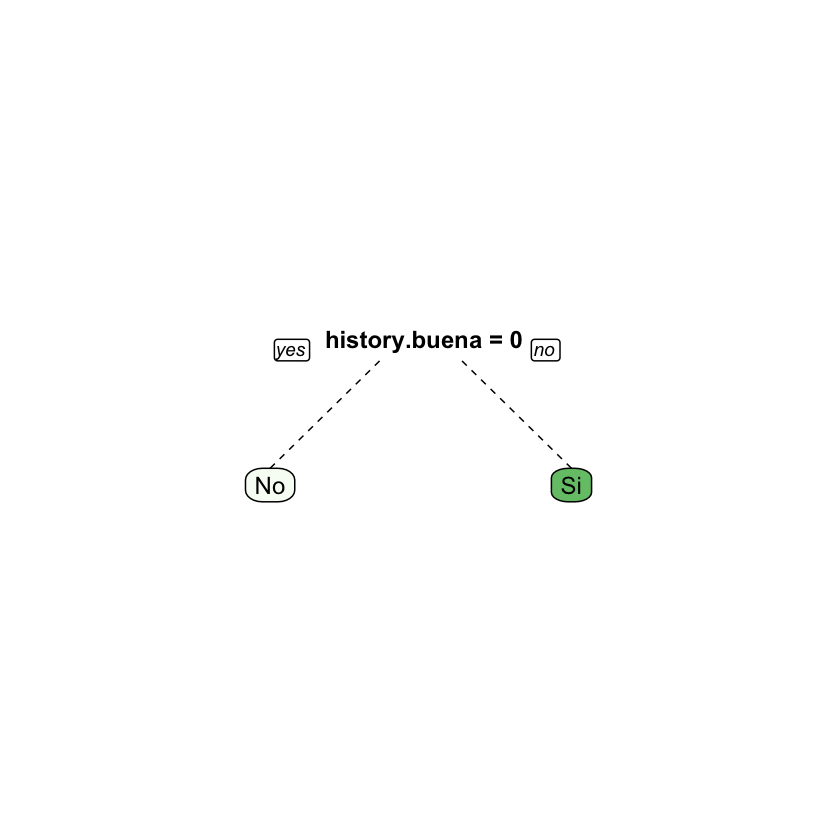

In [25]:
p_load("rpart.plot")
prp(class_arboles$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE)

## Bosques

In [26]:
set.seed(123)

class_bosques <- train(
    Default~duration+amount+installment+age+
                       history.buena+history.mala+
                       purpose.auto_nuevo+purpose.auto_usado+purpose.bienes+purpose.educacion+
                       foreign.extranjero+
                       +rent.TRUE, 
    data=train,
    method = "ranger",
    trControl = ctrl,
    tuneGrid=expand.grid(
              mtry = c(1,2,3,4,5,6,7,8),
              splitrule = "gini",
              min.node.size = c(15,30,45,60))
)

In [27]:
class_bosques

Random Forest 

700 samples
 12 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 561, 559, 560, 560 
Resampling results across tuning parameters:

  mtry  min.node.size  Accuracy   Kappa     
  1     15             0.7257189  0.01463238
  1     30             0.7228617  0.00000000
  1     45             0.7228617  0.00000000
  1     60             0.7228617  0.00000000
  2     15             0.7228823  0.08415766
  2     30             0.7243109  0.07520758
  2     45             0.7200149  0.03733218
  2     60             0.7185863  0.02270171
  3     15             0.7300353  0.16514766
  3     30             0.7314128  0.15073343
  3     45             0.7257294  0.10705687
  3     60             0.7257087  0.09518359
  4     15             0.7271780  0.18835057
  4     30             0.7357598  0.19024799
  4     45             0.7342905  0.16984246
  4     60             0.7328723  0.15401397
  5     15     

In [28]:
predictTest_bosque <- data.frame(
  obs = test$Default,                                    ## observed class labels
  predict(class_bosques, newdata = test, type = "prob"),         ## predicted class probabilities
  pred = predict(class_bosques, newdata = test, type = "raw")    ## predicted class labels
)


In [29]:
# Accuracy
mean(predictTest_bosque$obs==predictTest_bosque$pred)

[1] 0.7033333

## AdaBoost

In [30]:
p_load("adabag")

Tuning parameters:

   - mfinal (#Trees)
   - maxdepth (Max Tree Depth)
   - coeflearn (Coefficient Type) 
       - ’Breiman’(by default), $\alpha=\frac{1}{2}ln\left(\frac{(1-err)}{err}\right)$ 
       - ’Freund’ $\alpha=ln\left(\frac{(1-err)}{err}\right)$ 


In [31]:
set.seed(123)

class_adaboost <- train(
    Default~duration+amount+installment+age+
                       history.buena+history.mala+
                       purpose.auto_nuevo+purpose.auto_usado+purpose.bienes+purpose.educacion+
                       foreign.extranjero+
                       +rent.TRUE, 
    data=train,
    method = "AdaBoost.M1",
    trControl = ctrl,
    tuneGrid=expand.grid(
              mfinal = c(50,100,150),
              maxdepth = c(1,2,3),
              coeflearn = c('Breiman','Freund'))
)

In [32]:
class_adaboost

AdaBoost.M1 

700 samples
 12 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 561, 559, 560, 560 
Resampling results across tuning parameters:

  coeflearn  maxdepth  mfinal  Accuracy   Kappa        
  Breiman    1          50     0.7143107   0.0356556792
  Breiman    1         100     0.7114433   0.0050674355
  Breiman    1         150     0.7085759  -0.0003434487
  Breiman    2          50     0.7243515   0.1203032325
  Breiman    2         100     0.7143408   0.1052505695
  Breiman    2         150     0.7171573   0.1037756776
  Breiman    3          50     0.7172598   0.1767630858
  Breiman    3         100     0.7172088   0.1751191476
  Breiman    3         150     0.7215354   0.1859835908
  Freund     1          50     0.7328927   0.1417531958
  Freund     1         100     0.7242905   0.1098597575
  Freund     1         150     0.7185863   0.0882555762
  Freund     2          50     0.7228714   0.186198113

In [33]:
predictTest_ada <- data.frame(
  obs = test$Default,                                    ## observed class labels
  predict(class_adaboost, newdata = test, type = "prob"),         ## predicted class probabilities
  pred = predict(class_adaboost, newdata = test, type = "raw")    ## predicted class labels
)


In [34]:
# Accuracy
mean(predictTest_ada$obs==predictTest_ada$pred)

[1] 0.7033333

### Variable Importance Measures

- Bagging and Boosting typically results in improved accuracy over prediction using a single tree. 

- Unfortunately, however, it can be difficult to interpret the resulting model. Thus, aggregation improves prediction accuracy at the expense of interpretability.

- Although the collection of  trees is much more difficult to interpret than a single tree, one can obtain an overall summary of the importance of each predictor using the Gini index (RSS) for classification (Regression). 

-  In the context of  classification trees, we can add up the total amount that the Gini index is decreased by splits over a given predictor.

- A large value indicates an important predictor.

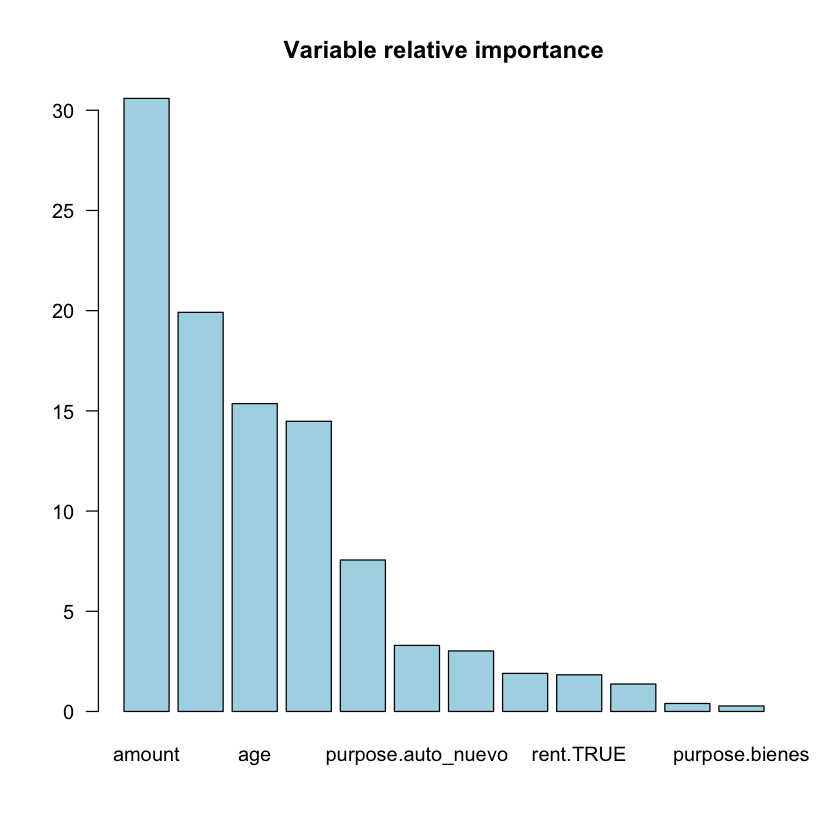

In [35]:
importanceplot(class_adaboost$finalModel)

In [36]:
data.frame(class_adaboost$finalModel$importance)

,class_adaboost.finalModel.importance
,<dbl>
age,15.3624574
amount,30.5917092
duration,19.9167929
foreign.extranjero,0.3981793
history.buena,14.4814104
history.mala,3.0203393
installment,1.3686423
purpose.auto_nuevo,3.2964775
purpose.auto_usado,7.5583119
